In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from scipy.io import loadmat
import pandas as pd

In [2]:
data = loadmat("data.mat")
print(data['Reduced_Data'])
df = pd.DataFrame(data['Reduced_Data'])

[[array([[ 0, 10, -5]], dtype=int16)
  array([[ 0.00000000e+00,  3.57201080e+01,  4.39831496e+01,
           4.98423001e+01,  5.45096723e+01,  5.83976141e+01,
           6.16975622e+01,  6.45196959e+01,  6.69388946e+01,
           6.90125208e+01,  7.07872017e+01,  7.23019278e+01,
           7.35900199e+01,  7.46799894e+01,  7.55968909e+01,
           7.63628138e+01,  7.69969281e+01,  7.75159806e+01,
           7.79345742e+01,  7.82659016e+01,  7.85212808e+01,
           7.87113974e+01,  7.88451476e+01,  7.89303117e+01,
           7.89737091e+01,  7.89819087e+01,  7.89600133e+01,
           7.89128858e+01,  7.88446422e+01,  7.87589087e+01,
           7.86589045e+01,  7.85474019e+01,  7.84268383e+01,
           7.82993344e+01,  7.81667865e+01,  7.80306990e+01,
           7.78923752e+01,  7.77530856e+01,  7.76135756e+01,
           7.74749109e+01,  7.73376229e+01,  7.72022867e+01,
           7.70694938e+01,  7.69395088e+01,  7.68127787e+01,
           7.66894673e+01,  7.65697802e+01,  7.6

In [3]:
def create_model(n_states=12, n_BCs=3, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(n_BCs), name="BCs")
    branch = tf.keras.layers.Dense(128, activation="tanh")(branch_input)
    branch = tf.keras.layers.Dense(64, activation="tanh")(branch)
    branch = tf.keras.layers.Dense(64, activation="tanh")(branch)
    
    # Trunk net
    trunk_input = tf.keras.Input(shape=(n_states), name="time")
    trunk = tf.keras.layers.Dense(128, activation="tanh")(trunk_input)   
    trunk = tf.keras.layers.Dense(64, activation="tanh")(trunk)
    trunk = tf.keras.layers.Dense(64, activation="tanh")(trunk)
    
    # Compute the dot product between branch and trunk net
    dot_product = tf.multiply(branch, trunk)
    
    # Add the bias
    output = tf.keras.layers.Dense(n_states)(dot_product)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)
    
    if verbose:
        model.summary()
        
    return model   

In [4]:
n_states = 8
deepOnet = create_model(n_states=n_states, verbose=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BCs (InputLayer)            [(None, 3)]                  0         []                            
                                                                                                  
 time (InputLayer)           [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  512       ['BCs[0][0]']                 
                                                                                                  
 dense_3 (Dense)             (None, 128)                  1152      ['time[0][0]']                
                                                                                             

In [5]:
# Wrangling the data
X_Branch = []
X_Trunk = []
for i in range(np.shape(df[0])[0]): # the number of simulations in the data set
    for j in range(np.shape(df[1][0])[1]): # the second index of the shape of the time series data
        X_Branch.append(np.array(df[0][i]))
        X_Trunk.append(np.array(df[1][i][:,j]))

X_Branch = np.array(X_Branch).reshape(np.shape(df[0])[0]*np.shape(df[1][0])[1],np.shape(df[0][0])[1])
X_Trunk = np.array(X_Trunk)

y = []
for k in range(np.shape(df[0])[0]):
    for l in range(np.shape(df[2][0])[1]): # the second index of the shape of the time series data
        y.append(np.array(df[2][k][:,l]))

y = np.array(y)

In [6]:
learn_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
deepOnet.compile(optimizer=optimizer,
                loss='mse',
                metrics=[keras.metrics.MeanSquaredError()])

In [7]:
fit = deepOnet.fit([X_Branch, X_Trunk], y, epochs=200)

Epoch 1/200

94/94 [==============================] - 2s 2ms/step - loss: 59.7425 - mean_squared_error: 59.7425
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 28.7974 - mean_squared_error: 28.7974
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 16.8060 - mean_squared_error: 16.8060
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 10.6408 - mean_squared_error: 10.6408
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 6.5427 - mean_squared_error: 6.5427
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 3.8688 - mean_squared_error: 3.8688
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3859 - mean_squared_error: 2.3859
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 1.5165 - mean_squared_error: 1.5165
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 1.0813 - mean_squared_error: 1.0813
Epoch 10/2

In [8]:
y_pred = deepOnet.predict([X_Branch, X_Trunk])


94/94 [==============================] - 0s 1ms/step


In [9]:
deepOnet.save(filepath="C:/Users/MorgadoBruno/Documents/ML_ROM_PROJECT_24/code/model", save_format='tf')

INFO:tensorflow:Assets written to: C:/Users/MorgadoBruno/Documents/ML_ROM_PROJECT_24/code/model\assets


INFO:tensorflow:Assets written to: C:/Users/MorgadoBruno/Documents/ML_ROM_PROJECT_24/code/model\assets


# Simulating ODE

In [10]:
FEM_r = loadmat("R_FE_Mats.mat")
FEM_r = FEM_r["Reduced_FE_Matrices"]

Kr = FEM_r[0][0][1]
Lr = FEM_r[0][0][2]
M_inv = FEM_r[0][0][3]


In [11]:
from scipy.integrate import solve_ivp

class source_vec():
    def __init__(self, model):
        self.model = model

    def predict_F(self, BCs, u):
        return self.model.predict([BCs, np.expand_dims(u, axis=0)])[0]

source = source_vec(deepOnet)

def dydt_func(t, u, M_inv, Kr, BCs, nn_object):
    F = nn_object.predict_F(BCs, u)
    dydt = M_inv@(F - Kr@u)

    return dydt

In [12]:
u0 = np.zeros([n_states,])
tlist = np.linspace(0,2,500)
BCs = np.expand_dims([100,-10,20], axis=0)
u = solve_ivp(fun=dydt_func, y0=u0, t_span=(0,2),t_eval=tlist, args=(M_inv, Kr, BCs, source), method="BDF")

1/1 [==============================] - 0s 30ms/step


In [13]:
print(u)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.008e-03 ...  1.996e+00  2.000e+00]
        y: [[ 0.000e+00 -9.287e+01 ... -5.330e+02 -5.330e+02]
            [ 0.000e+00 -3.906e+01 ...  2.479e+02  2.479e+02]
            ...
            [ 0.000e+00  1.150e+01 ...  3.033e+00  3.033e+00]
            [ 0.000e+00  2.256e-01 ...  1.839e-01  1.839e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 509
     njev: 14
      nlu: 79


In [14]:
temp_sensors_NN = Lr@np.array(u['y'])

1/1 [==============================] - 0s 18ms/step


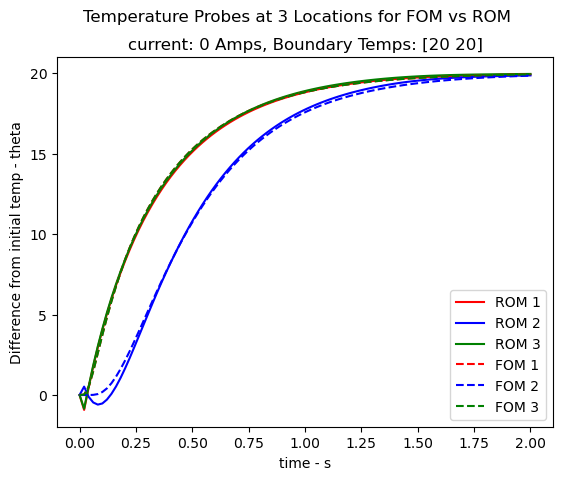

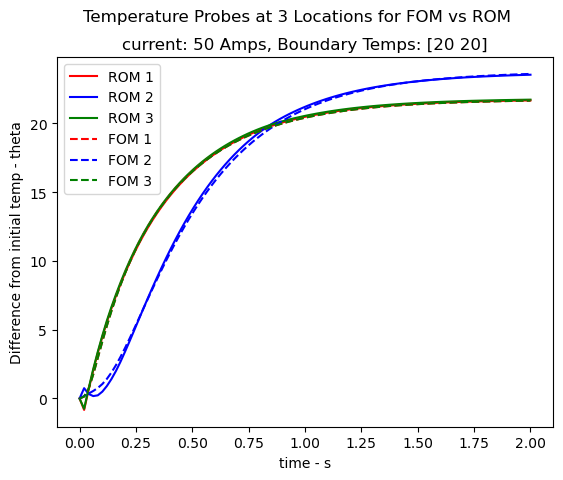

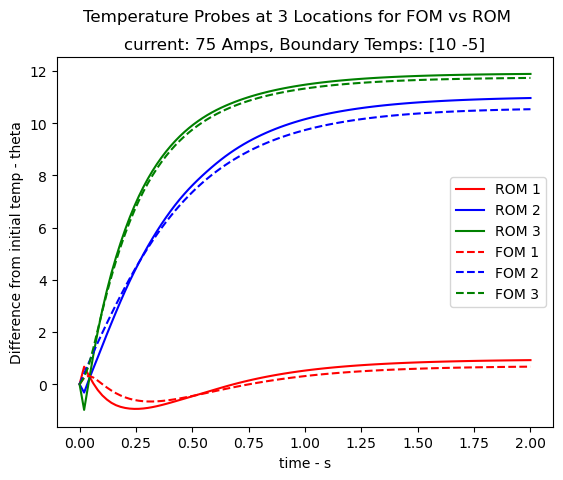

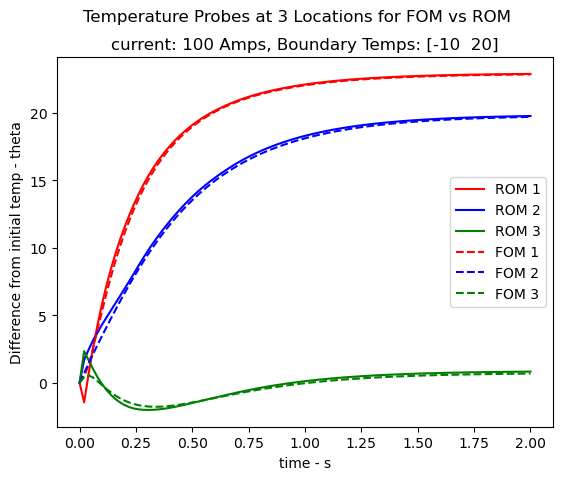

In [15]:
testing_data = loadmat("testing_data.mat")
testing_data= testing_data["testing_probes"]
u0 = np.zeros([n_states,])
tlist = np.linspace(0,2,100)

for i in range(np.shape(testing_data)[0]):
    BCs = testing_data[i][0]
    u = solve_ivp(fun=dydt_func, y0=u0, t_span=(0,2),t_eval=tlist, args=(M_inv, Kr, BCs, source), method="BDF")
    temp_sensors_NN = Lr@np.array(u['y'])
    plt.figure()
    plt.plot(tlist, temp_sensors_NN[0],'r' , label = 'ROM 1')
    plt.plot(tlist,temp_sensors_NN[1],'b', label = 'ROM 2')
    plt.plot(tlist,temp_sensors_NN[2],'g', label = 'ROM 3')
    plt.plot(tlist,testing_data[i][1][0],'r--' , label = 'FOM 1')
    plt.plot(tlist,testing_data[i][1][1],'b--', label = 'FOM 2')
    plt.plot(tlist,testing_data[i][1][2],'g--', label = 'FOM 3')
    plt.suptitle("Temperature Probes at 3 Locations for FOM vs ROM")
    plt.title("current: "+ str(testing_data[i][0][0][0])+" Amps, " + "Boundary Temps: " + str(testing_data[i][0][0][1:3]))
    plt.xlabel("time - s")
    plt.ylabel("Difference from initial temp - theta")
    plt.legend()



1/1 [==============================] - 0s 21ms/step


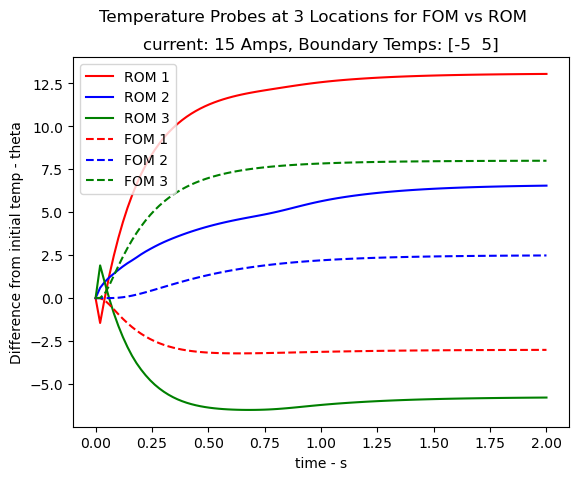

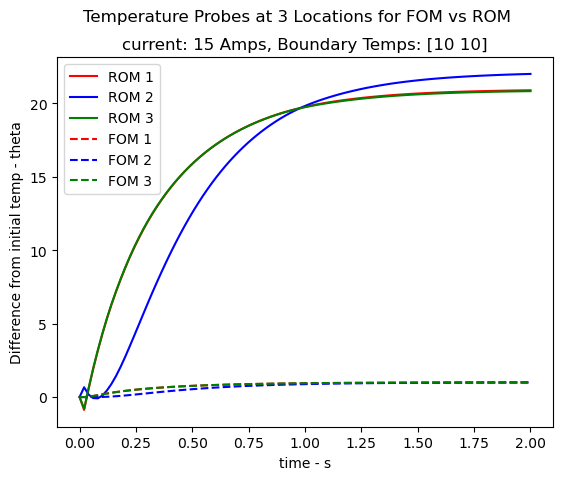

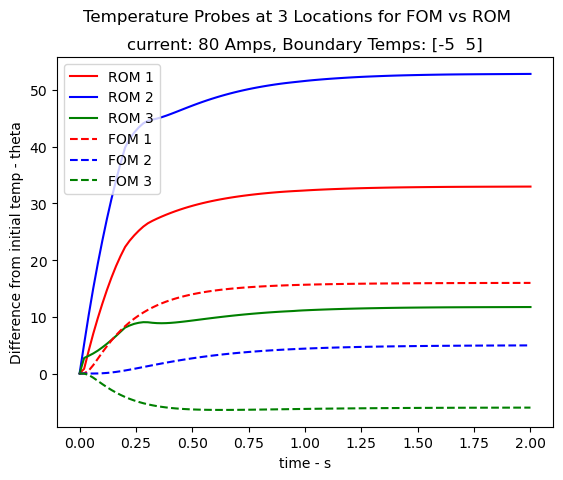

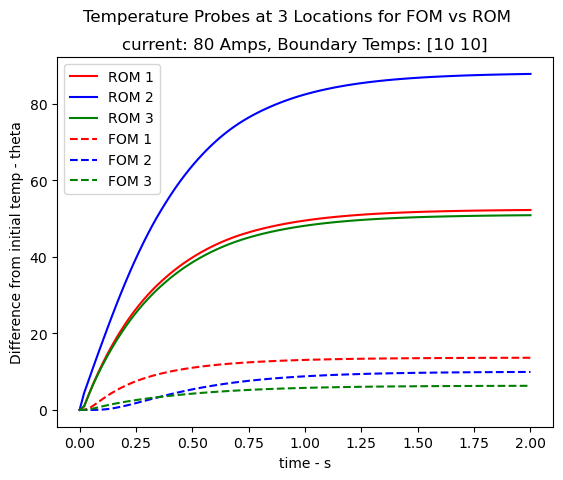

In [16]:
validation_data = loadmat("validation_data.mat")
validation_data= validation_data["validation_probes"]
u0 = np.zeros([n_states,])
tlist = np.linspace(0,2,100)

for i in range(np.shape(validation_data)[0]):
    BCs = validation_data[i][0]
    u = solve_ivp(fun=dydt_func, y0=u0, t_span=(0,2),t_eval=tlist, args=(M_inv, Kr, BCs, source), method="BDF")
    temp_sensors_NN = Lr@np.array(u['y'])
    plt.figure()
    plt.plot(tlist, temp_sensors_NN[0],'r' , label = 'ROM 1')
    plt.plot(tlist,temp_sensors_NN[1],'b', label = 'ROM 2')
    plt.plot(tlist,temp_sensors_NN[2],'g', label = 'ROM 3')
    plt.plot(tlist,validation_data[i][1][0],'r--' , label = 'FOM 1')
    plt.plot(tlist,validation_data[i][1][1],'b--', label = 'FOM 2')
    plt.plot(tlist,validation_data[i][1][2],'g--', label = 'FOM 3')
    plt.suptitle("Temperature Probes at 3 Locations for FOM vs ROM")
    plt.title("current: "+ str(validation_data[i][0][0][0])+" Amps, " + "Boundary Temps: " + str(validation_data[i][0][0][1:3]))
    plt.xlabel("time - s")
    plt.ylabel("Difference from initial temp - theta")
    plt.legend()

In [17]:
print(np.shape(np.array(testing_data[2][0])))


(1, 3)


Appendix

In [18]:
print(y_pred[1100])
print(y[1100])

[-2.4594343e+01 -1.4932169e+00 -3.4611862e+01  1.4414224e+01
 -4.4918334e-01 -1.2896888e-02 -7.6289251e-02  2.2653593e-01]
[-2.45963018e+01 -1.48836618e+00 -3.46215165e+01  1.44345541e+01
 -4.55571329e-01 -1.45862376e-02 -7.78028561e-02  2.29458442e-01]


In [19]:
print(np.array(df[2][1][:,0]))

[-1.22970060e+00 -7.45759826e-02 -1.73110498e+00  7.21816352e-01
 -2.25499088e-02 -7.41076188e-04 -3.93387048e-03  1.17068494e-02]


In [20]:
np.shape(df[1][0])[1]


100

In [21]:
np.shape(df[0][0])

(1, 3)

In [22]:
df[2][0][:,0]

array([ 6.01142548, 11.25975834, -8.18204244,  9.2112997 , -0.08628908,
        0.025601  , -0.01615428,  0.03906566])

In [23]:
x = deepOnet.predict([np.expand_dims(X_Branch[0], axis=0), np.expand_dims(X_Trunk[0], axis=0)])
print(deepOnet.predict([np.expand_dims(X_Branch[0], axis=0), np.expand_dims(X_Trunk[0], axis=0)]))
print(x[0])
# print(np.shape(np.newaxis(X_Branch[0])))
# np.expand_dims(X_Branch[0], axis=0)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step
[[ 5.990821   11.209837   -8.147827    9.1777725  -0.11778727  0.03675971
   0.02150229  0.03760078]]
[ 5.990821   11.209837   -8.147827    9.1777725  -0.11778727  0.03675971
  0.02150229  0.03760078]


In [24]:
print(X_Branch[500])

[ 0 20 20]


[[ 0.          0.14119537  0.71538182  1.75692088  2.9563337   4.15798678
   5.30294247  6.37252866  7.36351803  8.27894608  9.12423501  9.90571453
  10.62940819 11.30057636 11.92369331 12.50364927 13.04380773 13.54818606
  14.0193479  14.46039992 14.8734357  15.26080116 15.62431306 15.96534091
  16.28566181 16.5873811  16.87128487 17.13836745 17.39051523 17.62840769
  17.85241777 18.06410281 18.26413522 18.45265361 18.63085463 18.79937197
  18.95831918 19.108605   19.25070533 19.38424226 19.51041251 19.6297618
  19.7428358  19.85018023 19.95176226 20.04701276 20.13718892 20.22269921
  20.30395209 20.38135603 20.45442415 20.52302255 20.58803652 20.64974367
  20.70842163 20.764348   20.81693079 20.86647012 20.91341516 20.95795384
  21.00027409 21.04056384 21.07832553 21.11401941 21.14783252 21.17989919
  21.21035372 21.23925833 21.26602933 21.29132073 21.31523973 21.33789354
  21.35938937 21.37983442 21.3993359  21.41800102 21.43572781 21.45190292
  21.46721456 21.48173539 21.49553809 2

Text(0.5, 1.0, 'current: 100 Amps, Boundary Temps: [-10  20]')

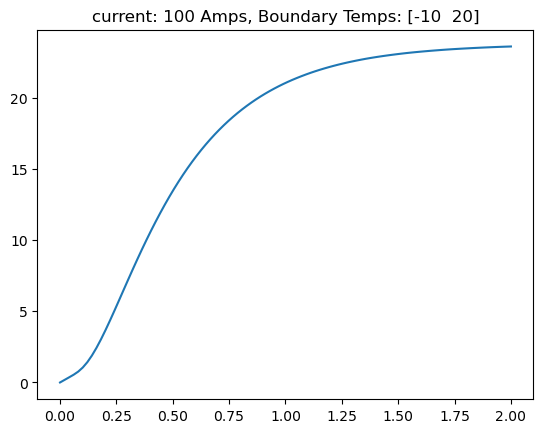

In [25]:
print(testing_data[1][1])
plt.plot(tlist,testing_data[1][1][1])
plt.title("current: "+ str(testing_data[i][0][0][0])+" Amps, " + "Boundary Temps: " + str(testing_data[i][0][0][1:3]) )